In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import louvain
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
%config InlineBackend.figure_format='retina'

# Loading the Data

In [3]:
SCATAC_DIR = '../data/scATAC/'

In [4]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_ids', cache=True)

var = pd.read_csv(SCATAC_DIR + 'var.csv')
scatac.var = var

obs = pd.read_csv(SCATAC_DIR + 'obs.csv')
scatac.obs = obs

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


CPU times: user 39.7 s, sys: 2min 30s, total: 3min 10s
Wall time: 3min 53s


In [5]:
scatac

AnnData object with n_obs × n_vars = 70461 × 506543 
    obs: 'Unnamed: 0', 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification'
    var: 'score', 'scoreQuantile', 'name', 'GC'

In [6]:
scatac.obs.head()

,Unnamed: 0,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,ProjectUMAP1,ProjectUMAP2,ProjectClassification
0,BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,-7.257169,-3.767484,07_GMP
1,BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,9.737446,-2.393460,22_CD4.M
2,BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,1.359905,12.922869,02_Early.Eryth
3,BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,11.522385,1.818643,24_CD8.CM
4,BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,10.663303,0.689267,24_CD8.CM


# Data Cleaning

In [8]:
scatac.obs.set_index('Unnamed: 0', inplace=True)

In [10]:
scatac.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [11]:
scatac.obsm['X_umap'] = scatac.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scatac.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [12]:
scatac.obs['condition'] = scatac.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [14]:
scatac.obs

,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,cell_type,condition
Unnamed: 0,,,,,,,,,,
BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,07_GMP,control
BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,22_CD4.M,control
BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,02_Early.Eryth,control
BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,24_CD8.CM,control
BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,24_CD8.CM,control
...,...,...,...,...,...,...,...,...,...,...
RM9_2132,0.367928,11100,MPAL5_R1,ACTAACGAGGTACATA-1,Cluster4,-3.900144,11.570778,Cluster4,Healthy_Like,stimulated
RM9_2134,0.335893,20054,MPAL5_R1,TAACAGCCATCATAGC-1,Cluster8,-3.257237,-4.751131,Cluster8,Healthy_Like,stimulated
RM9_2101,0.275620,16530,MPAL5_R1,AAACTCGGTCTGTTGA-1,Cluster40,0.890739,4.249907,Cluster40,Lymphoid_Like,stimulated


# Visualization

... storing 'Group' as categorical
... storing 'Barcode' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'cell_type' as categorical
... storing 'condition' as categorical


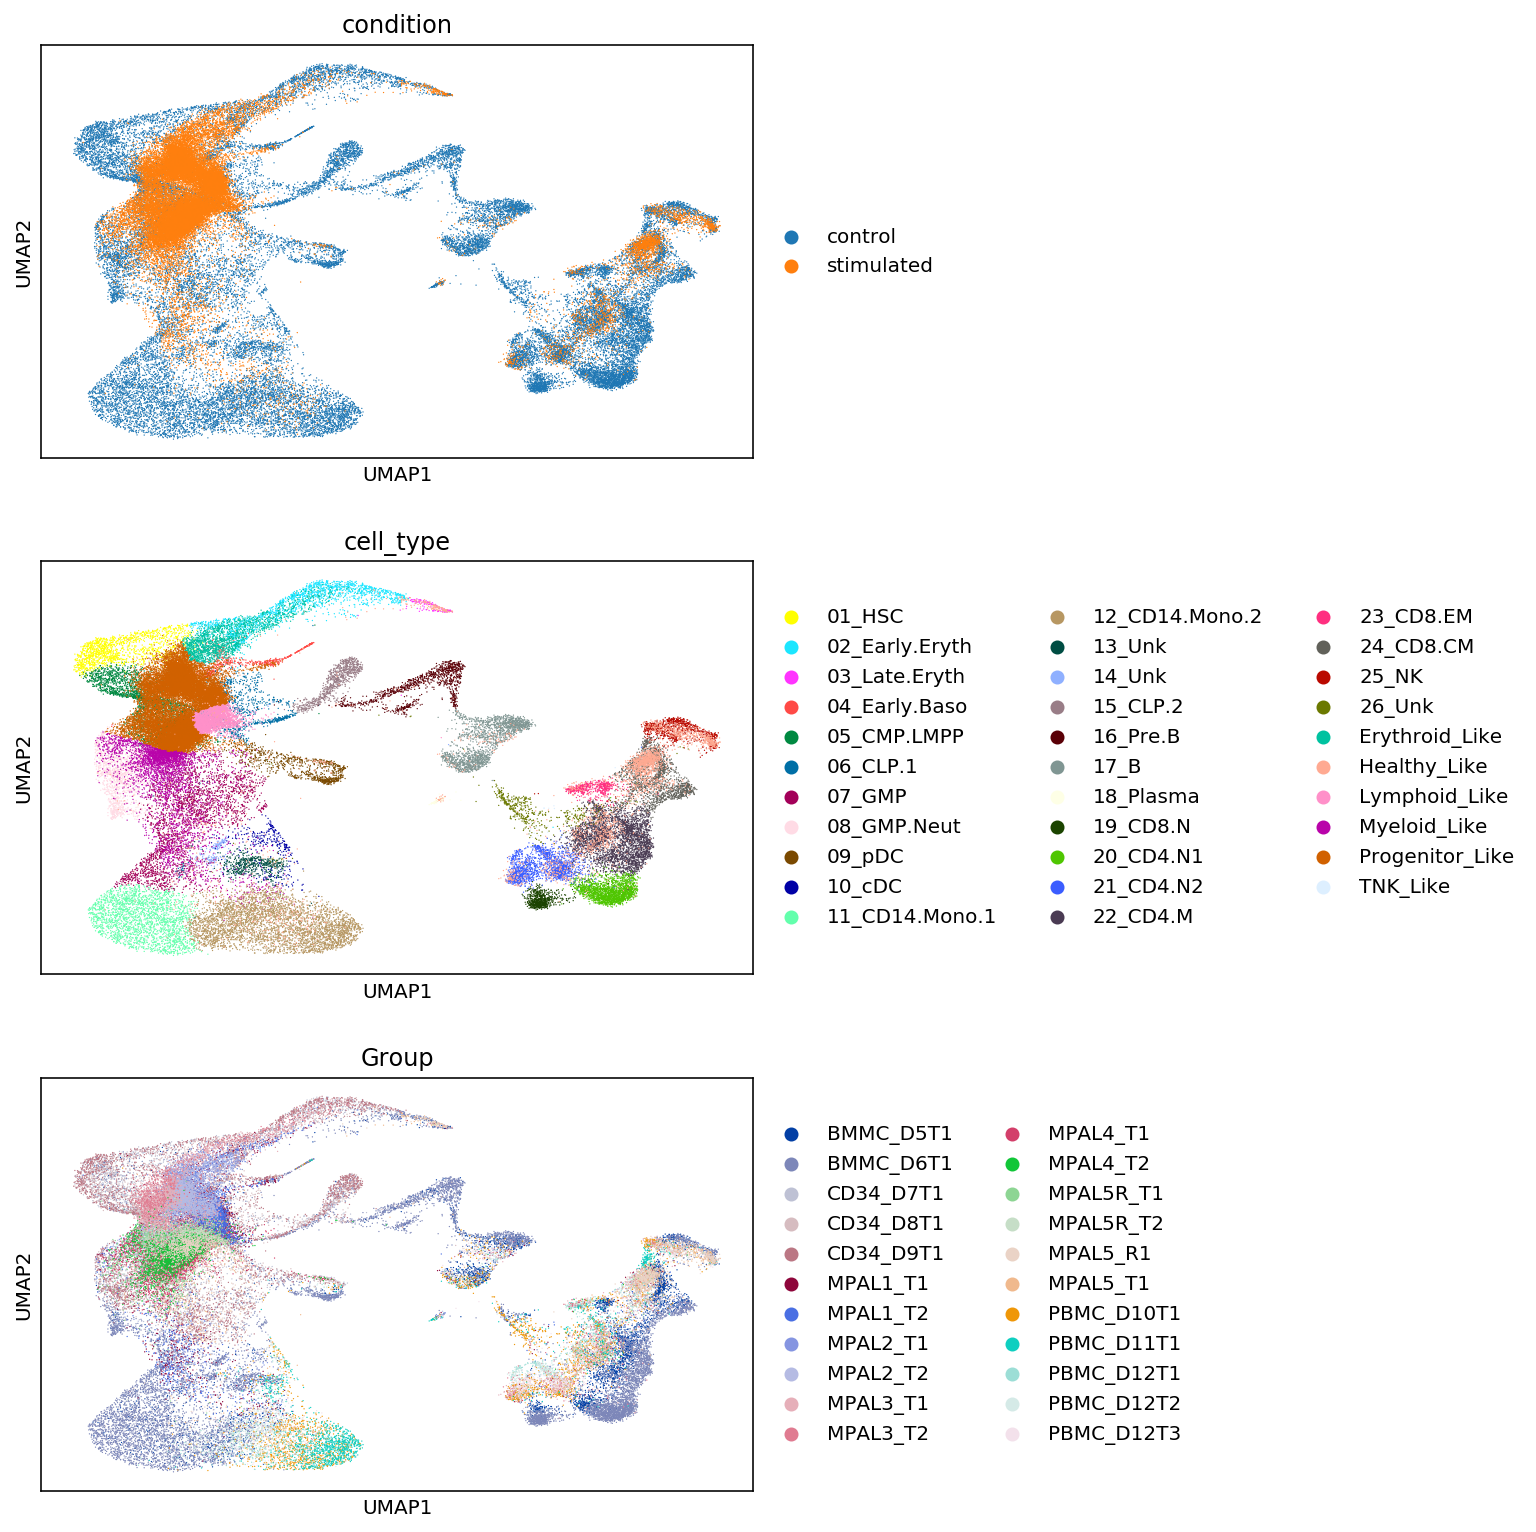

In [15]:
sc.pl.umap(scatac, color=['condition', 'cell_type', 'Group'], ncols=1)

Transforming to str index.


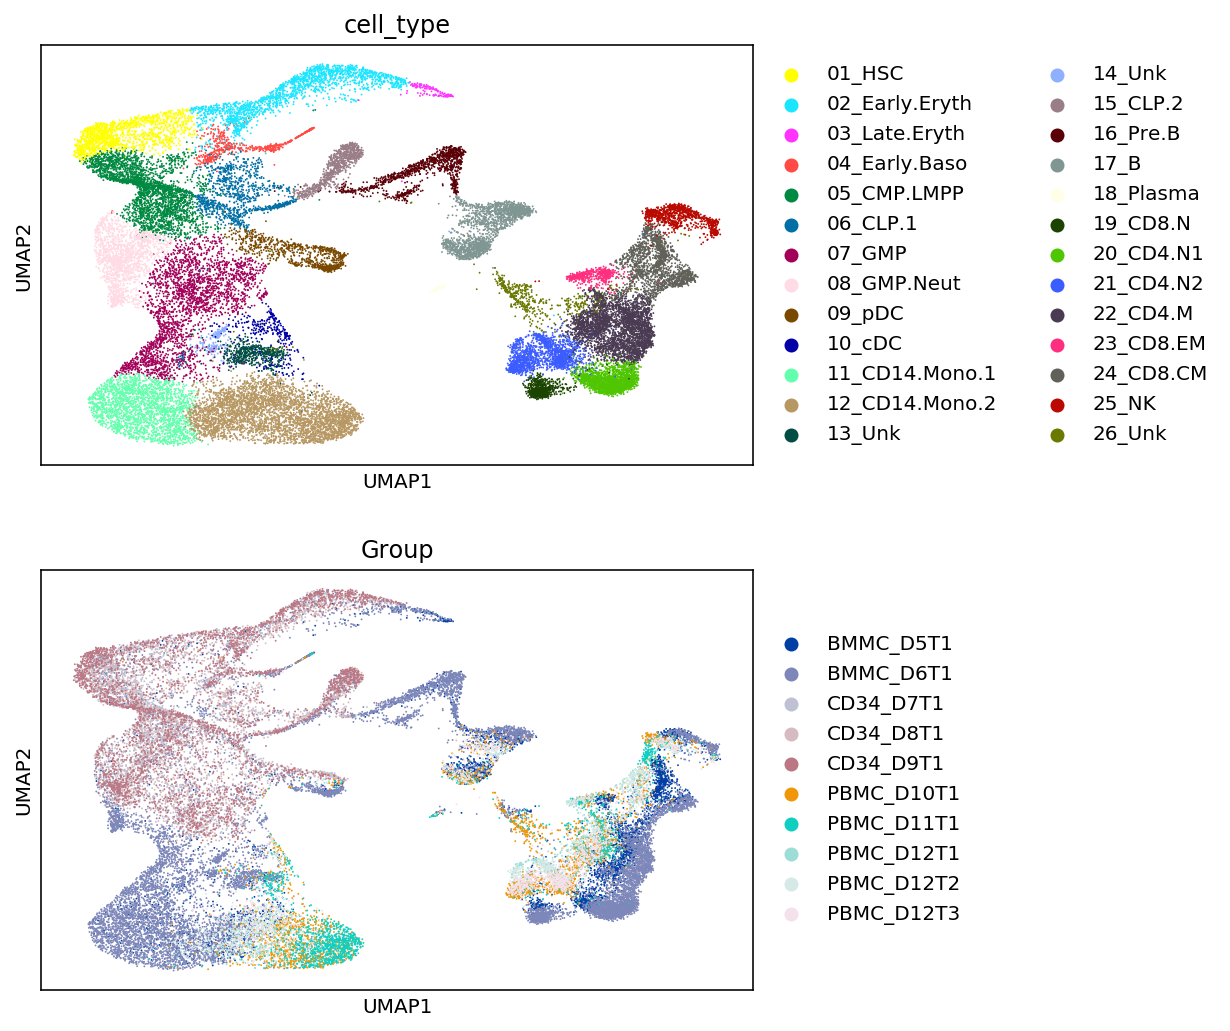

In [17]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

Transforming to str index.


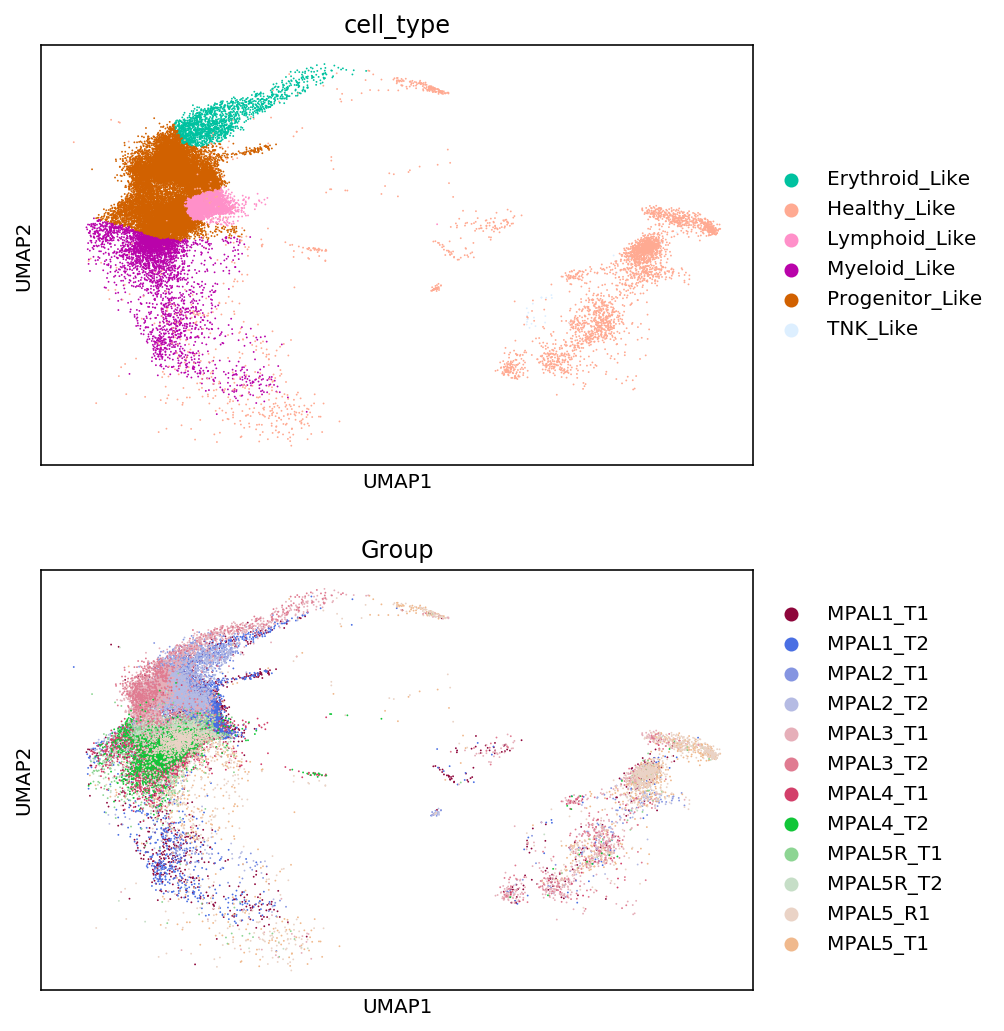

In [18]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# Preprocessing

In [19]:
%time scatac = epi.pp.binarize(scatac, copy=True)

Transforming to str index.


CPU times: user 54 s, sys: 1min 6s, total: 2min
Wall time: 2min 58s


In [20]:
scatac

AnnData object with n_obs × n_vars = 70461 × 506543 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition'
    var: 'score', 'scoreQuantile', 'name', 'GC'
    uns: 'condition_colors', 'cell_type_colors', 'Group_colors'
    obsm: 'X_umap'

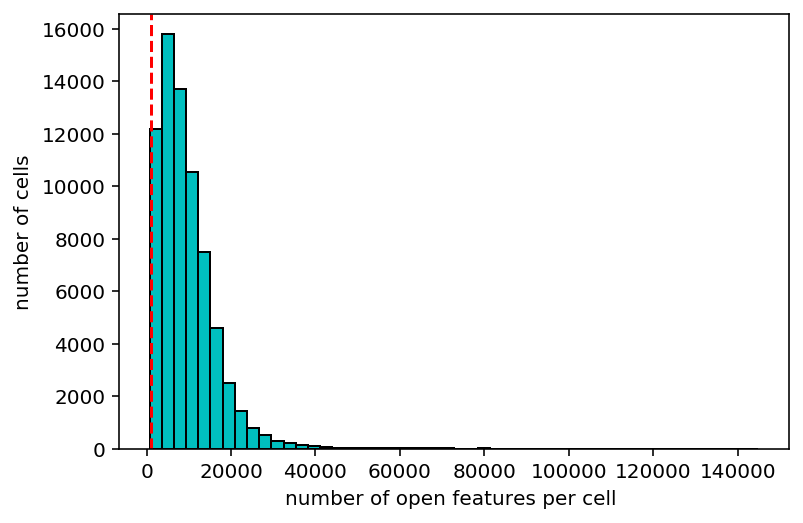

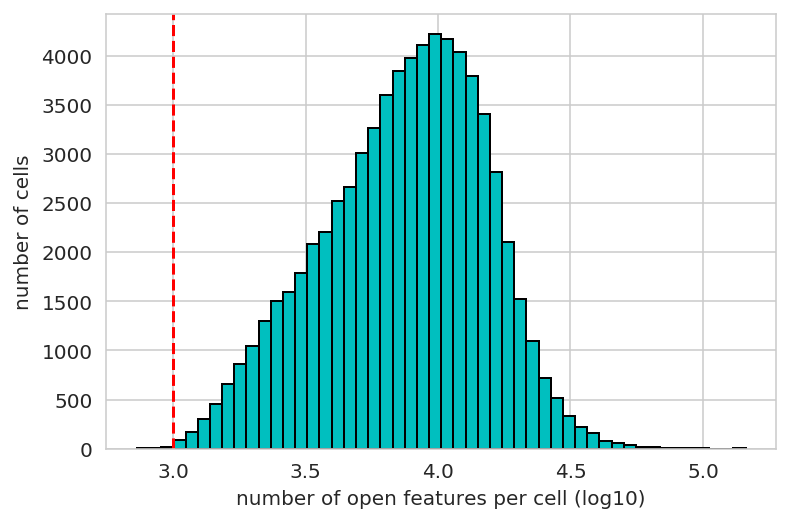

In [21]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

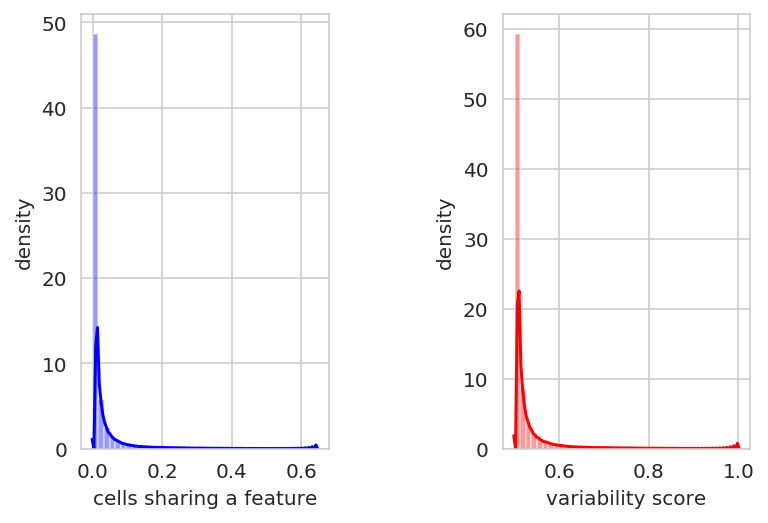

In [22]:
epi.pp.cal_var(scatac)

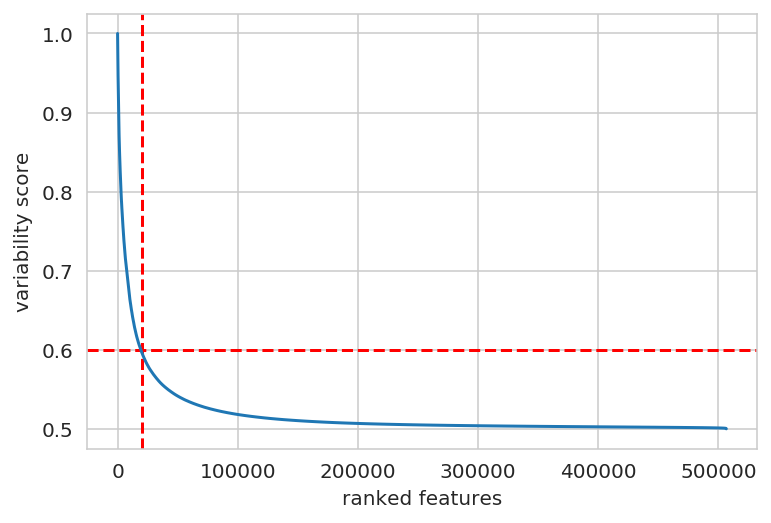

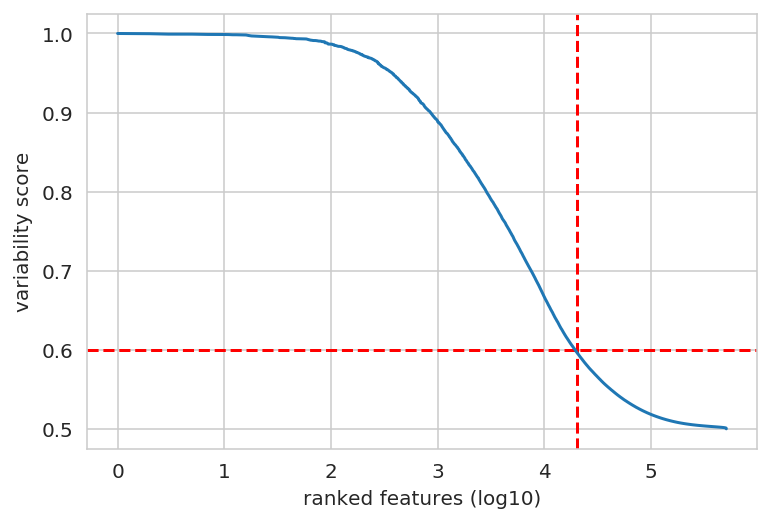

In [23]:
min_score_value = 0.6
nb_feature_selected = 20000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

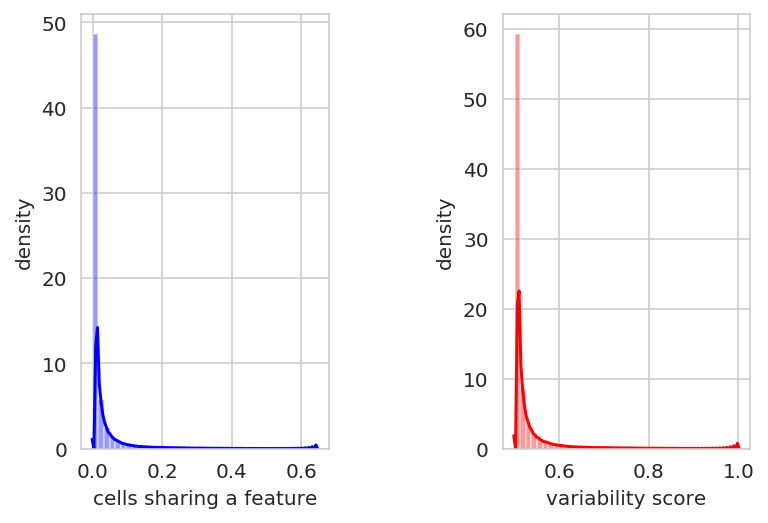

CPU times: user 18.4 s, sys: 10.1 s, total: 28.5 s
Wall time: 28.8 s


In [24]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [25]:
%%time
epi.pp.normalize_per_cell(scatac)
epi.pp.log1p(scatac)

Trying to set attribute `.obs` of view, making a copy.


CPU times: user 7.51 s, sys: 6.8 s, total: 14.3 s
Wall time: 14.5 s


In [26]:
scatac

AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'condition_colors', 'cell_type_colors', 'Group_colors'
    obsm: 'X_umap'

In [27]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 1.43 s, sys: 2.18 s, total: 3.62 s
Wall time: 20.7 s
